# Streaming

In [1]:
import boto3

def generate_conversation(messages,
                          system_prompts=[],
                          inference_config={},
                          additional_model_fields={},
                          ):

    bedrock_client = boto3.client(service_name='bedrock-runtime', region_name="us-west-2")
    model_id = "anthropic.claude-3-5-sonnet-20241022-v2:0"

    # Send the message.
    response = bedrock_client.converse(
        modelId=model_id,
        messages=messages,
        system=system_prompts,
        inferenceConfig=inference_config,
        additionalModelRequestFields=additional_model_fields
    )

    return response["output"]["message"]["content"][0]["text"]

messages = [{
    "role": "user",
    "content": [{"text": "hello world"}]
}]

generate_conversation(messages)

"Hi there! I'm happy to help you with any questions you have."

Streaming enables us to write applications that receive content as it is generated by the model, rather than having to wait for the entire response to be generated. This is how apps like claude.ai work. As the model generates responses, that content is streamed to a user's browser and displayed:

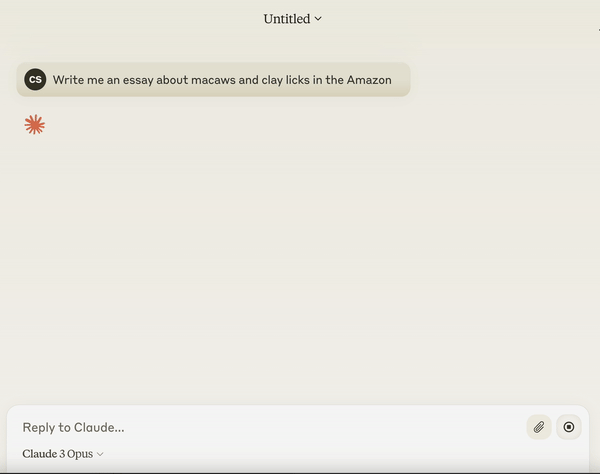

## Working with streams

To get a streaming response from the API, it's as simple as passing `stream=True` to `client.messages.create`.  That's the easy part. Where things get a little trickier is in how we subsequently work with the streaming response and handle incoming data. 

In [2]:
import boto3

def generate_conversation(messages,
                          system_prompts=[],
                          inference_config={},
                          additional_model_fields={},
                          ):

    bedrock_client = boto3.client(service_name='bedrock-runtime', region_name="us-west-2")
    model_id = "anthropic.claude-3-5-sonnet-20241022-v2:0"

    # Send the message.
    response = bedrock_client.converse_stream(
        modelId=model_id,
        messages=messages,
        system=system_prompts,
        inferenceConfig=inference_config,
        additionalModelRequestFields=additional_model_fields
    )

    return response["stream"]

messages = [{
    "role": "user",
    "content": [{"text": "hello world"}]
}]

stream = generate_conversation(messages)

Let's take a look at our `stream` variable

In [3]:
stream

There's not much to look at!  This stream object on its own won't do a whole lot for us. The stream object is a generator object that yields individual server-sent events (SSE) as they are received from the API. We need to write code to iterate over it and work with each individual server-sent event.  Remember, our data is no longer coming in one finalized chunk of data.  Let's try iterating over the stream response:

In [4]:
for event in stream:
    print(event)

{'messageStart': {'role': 'assistant'}}
{'contentBlockDelta': {'delta': {'text': 'Hi'}, 'contentBlockIndex': 0}}
{'contentBlockDelta': {'delta': {'text': '!'}, 'contentBlockIndex': 0}}
{'contentBlockDelta': {'delta': {'text': " I'm here"}, 'contentBlockIndex': 0}}
{'contentBlockDelta': {'delta': {'text': ' to help'}, 'contentBlockIndex': 0}}
{'contentBlockDelta': {'delta': {'text': '.'}, 'contentBlockIndex': 0}}
{'contentBlockDelta': {'delta': {'text': " What's"}, 'contentBlockIndex': 0}}
{'contentBlockDelta': {'delta': {'text': ' on your mind?'}, 'contentBlockIndex': 0}}
{'contentBlockStop': {'contentBlockIndex': 0}}
{'messageStop': {'stopReason': 'end_turn'}}
{'metadata': {'usage': {'inputTokens': 9, 'outputTokens': 17, 'totalTokens': 26}, 'metrics': {'latencyMs': 613}}}


As you can see, we ended up receiving many server-sent events from the API.  Let's take a closer look at what these events mean. This is a color-coded explanation of the events:

All of the actual model-generated content we care about comes from the ContentBlockDeltaEvents, which each contain a type set to "content_block_delta."  To actually get the content itself, we want to access the `text` property inside of `delta`.  Let's try exclusively printing out the text that was generated:

In [5]:
bedrock_client = boto3.client(service_name='bedrock-runtime', region_name="us-west-2")
model_id = "anthropic.claude-3-5-sonnet-20241022-v2:0"

messages = [{
    "role": "user",
    "content": [{"text": "Write me a 3 word sentence, without a preamble.  Just give me 3 words"}]
}]


# Send the message.
response = bedrock_client.converse_stream(
    modelId=model_id,
    messages=messages,
)


for event in response["stream"]:
    if 'messageStart' in event:
        print(f"\nRole: {event['messageStart']['role']}")

    if 'contentBlockDelta' in event:
        print(event['contentBlockDelta']['delta']['text'], end="")

    if 'messageStop' in event:
        print(f"\nStop reason: {event['messageStop']['stopReason']}")

    if 'metadata' in event:
        metadata = event['metadata']
        if 'usage' in metadata:
            print("\nToken usage")
            print(f"Input tokens: {metadata['usage']['inputTokens']}")
            print(
                f":Output tokens: {metadata['usage']['outputTokens']}")
            print(f":Total tokens: {metadata['usage']['totalTokens']}")
        if 'metrics' in event['metadata']:
            print(
                f"Latency: {metadata['metrics']['latencyMs']} milliseconds")




Role: assistant
Dogs chase cats.
Stop reason: end_turn

Token usage
Input tokens: 30
:Output tokens: 7
:Total tokens: 37
Latency: 538 milliseconds


We are successfully printing out the content, though the way it's formatted is a little tricky to read.  When printing out the streamed text using Python's `print()` function, it's useful to pass two additional arguments:
* `end=""`: By default, the print() function adds a newline character (\n) at the end of the printed text. However, by setting end="", we specify that the printed text should not be followed by a newline character. This means that the next print() statement will continue printing on the same line.
* `flush=True`: The flush parameter is set to True to force the output to be immediately written to the console or standard output, without waiting for a newline character or the buffer to be filled. This ensures that the text is displayed in real-time as it is received from the streaming response.

Let's try making these changes: 

In [6]:
bedrock_client = boto3.client(service_name='bedrock-runtime', region_name="us-west-2")
model_id = "anthropic.claude-3-5-sonnet-20241022-v2:0"

messages = [{
    "role": "user",
    "content": [{"text": "Write me a 3 word sentence, without a preamble.  Just give me 3 words"}]
}]


# Send the message.
response = bedrock_client.converse_stream(
    modelId=model_id,
    messages=messages,
)


for event in response["stream"]:
    if 'messageStart' in event:
        print(f"\nRole: {event['messageStart']['role']}")

    if 'contentBlockDelta' in event:
        print(event['contentBlockDelta']['delta']['text'], end="")

    if 'messageStop' in event:
        print(f"\nStop reason: {event['messageStop']['stopReason']}")

    if 'metadata' in event:
        metadata = event['metadata']
        if 'usage' in metadata:
            print("\nToken usage")
            print(f"Input tokens: {metadata['usage']['inputTokens']}")
            print(
                f":Output tokens: {metadata['usage']['outputTokens']}")
            print(f":Total tokens: {metadata['usage']['totalTokens']}")
        if 'metrics' in event['metadata']:
            print(
                f"Latency: {metadata['metrics']['latencyMs']} milliseconds")




Role: assistant
Dogs chase cats.
Stop reason: end_turn

Token usage
Input tokens: 30
:Output tokens: 7
:Total tokens: 37
Latency: 559 milliseconds


With such a short piece of text, the streaming functionality may not be obvious.  Let's try asking the model to generate something longer:

In [7]:
bedrock_client = boto3.client(service_name='bedrock-runtime', region_name="us-west-2")
model_id = "anthropic.claude-3-5-sonnet-20241022-v2:0"

messages = [{
    "role": "user",
    "content": [{"text": "How do large language models work?"}]
}]


# Send the message.
response = bedrock_client.converse_stream(
    modelId=model_id,
    messages=messages,
)


for event in response["stream"]:
    if 'messageStart' in event:
        print(f"\nRole: {event['messageStart']['role']}")

    if 'contentBlockDelta' in event:
        print(event['contentBlockDelta']['delta']['text'], end="")

    if 'messageStop' in event:
        print(f"\nStop reason: {event['messageStop']['stopReason']}")

    if 'metadata' in event:
        metadata = event['metadata']
        if 'usage' in metadata:
            print("\nToken usage")
            print(f"Input tokens: {metadata['usage']['inputTokens']}")
            print(
                f":Output tokens: {metadata['usage']['outputTokens']}")
            print(f":Total tokens: {metadata['usage']['totalTokens']}")
        if 'metrics' in event['metadata']:
            print(
                f"Latency: {metadata['metrics']['latencyMs']} milliseconds")




Role: assistant
Large Language Models (LLMs) are complex AI systems that use deep learning techniques to process and generate human-like text. Here's a simplified explanation of how they work:

1. Architecture:
- LLMs are based on transformer architecture, which uses attention mechanisms
- They consist of billions of parameters (weights and biases) arranged in neural networks

2. Training:
- Pre-trained on massive amounts of text data from the internet
- Learn patterns and relationships between words and concepts
- Use supervised and unsupervised learning techniques
- Training is computationally intensive and expensive

3. Key components:
- Tokenization: Breaking text into smaller units (words or subwords)
- Embeddings: Converting tokens into numerical vectors
- Attention layers: Learning relationships between different parts of text
- Feed-forward networks: Processing information

4. Operation:
- Takes input text (prompt)
- Predicts the most likely next tokens based on training
- Gen

Try running the above cell if you haven't already.  You should see text content printed out incrementally as it comes in!

In [8]:
bedrock_client = boto3.client(service_name='bedrock-runtime', region_name="us-west-2")
model_id = "anthropic.claude-3-5-sonnet-20241022-v2:0"

messages = [{
    "role": "user",
    "content": [{"text": "How do large language models work?"}]
}]


# Send the message.
response = bedrock_client.converse_stream(
    modelId=model_id,
    messages=messages,
)


for event in response["stream"]:
    if 'messageStart' in event:
        print(f"\nRole: {event['messageStart']['role']}")

    if 'contentBlockDelta' in event:
        print(event['contentBlockDelta']['delta']['text'], end="")

    if 'messageStop' in event:
        print(f"\nStop reason: {event['messageStop']['stopReason']}")

    if 'metadata' in event:
        metadata = event['metadata']
        if 'usage' in metadata:
            print("\nToken usage")
            print(f"Input tokens: {metadata['usage']['inputTokens']}")
            print(
                f":Output tokens: {metadata['usage']['outputTokens']}")
            print(f":Total tokens: {metadata['usage']['totalTokens']}")
        if 'metrics' in event['metadata']:
            print(
                f"Latency: {metadata['metrics']['latencyMs']} milliseconds")




Role: assistant
Large Language Models (LLMs) work through several key components and processes. Here's a simplified explanation:

1. Training Process:
- LLMs are trained on massive amounts of text data from the internet, books, and other sources
- They learn patterns in language by predicting the next word in sequences
- They use neural networks with billions of parameters to capture these patterns

2. Key Components:
- Transformer architecture: The foundation of modern LLMs
- Attention mechanisms: Help the model focus on relevant parts of input text
- Multiple layers: Process information at different levels of abstraction

3. Basic Operation:
- Input text is converted to numerical tokens
- The model processes these tokens through multiple layers
- It generates predictions based on learned patterns
- Output is converted back to text

4. Key Features:
- Contextual understanding
- Pattern recognition
- Probability-based prediction
- Zero-shot and few-shot learning capabilities

5. Limit

### Other streaming event types

When working with streams, you may encounter some other event types including:

* **Ping events** - streams may also include any number of ping events.
* **Error events** - you may occasionally see error events in the event stream. For example, during periods of high usage, you may receive an overloaded_error, which would normally correspond to an HTTP 529 in a non-streaming context.

Here's an example error event: 

```
event: error
data: {"type": "error", "error": {"type": "overloaded_error", "message": "Overloaded"}}
```


## Time to first token (TTFT)

The major reason to use streaming is to improve your time to first token: that amount of time it takes for you or your user to receive the first bit of model generated content. 
Let's try and demonstrate the impact that streaming can have on TTFT.

We'll start with a non-streaming approach.  We'll ask the model to generate a very long piece of text but cut it off at 500 tokens:

In [9]:
import time
def measure_non_streaming_ttft():
    start_time = time.time()

    response = client.messages.create(
        max_tokens=500,
        messages=[
            {
                "role": "user",
                "content": "Write mme a long essay explaining the history of the American Revolution",
            }
        ],
        temperature=0,
        model="anthropic.claude-3-5-sonnet-20241022-v2:0",
    )

    response_time = time.time() - start_time

    print(f"Time to receive first token: {response_time:.3f} seconds")
    print(f"Time to recieve complete response: {response_time:.3f} seconds")
    print(f"Total tokens generated: {response.usage.output_tokens}")
    
    print(response.content[0].text)

In [10]:
measure_non_streaming_ttft()

NameError: name 'client' is not defined

Now let's try the same thing using a streaming approach:

In [ ]:
def measure_streaming_ttft():
    start_time = time.time()

    stream = client.messages.create(
        max_tokens=500,
        messages=[
            {
                "role": "user",
                "content": "Write mme a long essay explaining the history of the American Revolution",
            }
        ],
        temperature=0,
        model="anthropic.claude-3-5-sonnet-20241022-v2:0",
        stream=True
    )
    have_received_first_token = False
    for event in stream:
        if event.type == "content_block_delta":
            if not have_received_first_token:
                ttft = time.time() - start_time
                have_received_first_token = True
            print(event.delta.text, flush=True, end="")
        elif event.type == "message_delta":
            output_tokens = event.usage.output_tokens
            total_time = time.time() - start_time

    print(f"\nTime to receive first token: {ttft:.3f} seconds", flush=True)
    print(f"Time to recieve complete response: {total_time:.3f} seconds", flush=True)
    print(f"Total tokens generated: {output_tokens}", flush=True)
    


In [ ]:
measure_streaming_ttft()

Here is a long essay explaining the history of the American Revolution:

The American Revolution was a pivotal event in the history of the United States, marking the country's transition from a collection of British colonies to an independent nation. The roots of the revolution can be traced back to the French and Indian War, which was fought between Britain and France from 1754 to 1763. This conflict, which was part of a larger global war, resulted in the British gaining control of much of North America, including the French colonies. However, the war also left Britain with a significant debt, which it sought to recoup by imposing a series of taxes and regulations on its American colonies.

One of the first major events that led to the American Revolution was the Stamp Act, which was passed by the British Parliament in 1765. This act required all printed materials in the colonies, including newspapers, pamphlets, bills, legal documents, licenses, almanacs, dice, and playing cards, to 

## Streaming helpers

The Python SDK provides several conveniences for streaming messages. Instead of using `client.messages.create` with `stream=True`, we can instead use `client.messages.stream` which gives us access to useful helper methods. `client.messages.stream()` returns a MessageStreamManager, which is a context manager that yields a MessageStream which is iterable, emits events, and accumulates messages. 

The code below uses `client.messages.stream` which allows us to use helpers like `stream.text_stream` to easily access generated text content as it streams in, without having to manually check the stream event type.  `stream.text_stream` provides an iterator over just the text deltas in the stream.

There are other useful helper methods like `get_final_message` which returns a final accumulated message once the stream has been read to completion.  This can be useful if you both want to use streaming but also need access to the entire finished text generation when it's complete.  You can of course write some code to build up your own accumulated message, but this helper method makes it easy.

The following example prints out each incoming piece of text as it is received, and also prints out the final completed message when the stream is complete:


In [ ]:
async def streaming_with_helpers():
    async with client.messages.stream(
        max_tokens=1024,
        messages=[
            {
                "role": "user",
                "content": "Write me sonnet about orchids",
            }
        ],
        model="anthropic.claude-3-5-sonnet-20241022-v2:0",
    ) as stream:
        async for text in stream.text_stream:
            print(text, end="", flush=True)

    final_message = await stream.get_final_message()
    print("\n\nSTREAMING IS DONE.  HERE IS THE FINAL ACCUMULATED MESSAGE: ")
    print(final_message.to_json())

await streaming_with_helpers()

***

## Exercise

Write a simple Claude chatbot that uses streaming. The following gif illustrates how it should work.  Please note that the color-coding of the output is completely optional and mostly helps to make the gif readable/watchable:

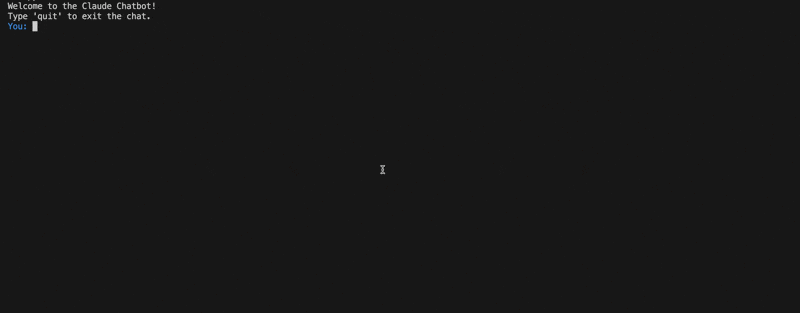

In [ ]:
# ANSI color codes
BLUE = "\033[94m"
GREEN = "\033[92m"
RESET = "\033[0m"

def chat_with_claude():
    print("Welcome to the Claude Chatbot!")
    print("Type 'quit' to exit the chat.")
    
    conversation = []
    
    while True:
        user_input = input(f"{BLUE}You: {RESET}")
        
        if user_input.lower() == 'quit':
            print("Goodbye!")
            break
        
        conversation.append({"role": "user", "content": user_input})
        
        print(f"{GREEN}Claude: {RESET}", end="", flush=True)
        
        stream = client.messages.create(
            model="anthropic.claude-3-5-sonnet-20241022-v2:0",
            max_tokens=1000,
            messages=conversation,
            stream=True
        )
        
        assistant_response = ""
        for chunk in stream:
            if chunk.type == "content_block_delta":
                content = chunk.delta.text
                print(f"{GREEN}{content}{RESET}", end="", flush=True)
                assistant_response += content
        
        print()  # New line after the complete response
        
        conversation.append({"role": "assistant", "content": assistant_response})

if __name__ == "__main__":
    chat_with_claude()



Welcome to the Claude Chatbot!
Type 'quit' to exit the chat.
You: hi
Claude: Hello! How can I help you today?
You: sup
Claude: Not much, just here to help! What's on your mind?


***